In [1]:
import torch
import glob as gb
import numpy as np
from PIL import Image
import os

import random
import torch.nn as nn
import pandas as pd 

from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random

from facenet_pytorch import MTCNN, InceptionResnetV1
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

os.sys.path.append('../')
os.sys.path.append('../models/')
from utils.loss import cos_sim

random.seed(1)
np.random.seed(1)

In [2]:
# SR Model Initialization

GPU_IN_USE = torch.cuda.is_available()

if GPU_IN_USE:
    cudnn.benchmark = True
    
device = torch.device('cuda' if GPU_IN_USE else 'cpu')

In [70]:
# Testing upsampling via SR
class SuperResolveDL:
    def __init__(self, model, size, channel, resize=True):
        self.model = model
        self.size = size
        self.channel = channel
        self.resize = resize
        
    def __call__(self, path=''):
        if self.channel == 1:
            img = Image.open(path).convert('YCbCr').resize((self.size,self.size),resample=Image.BICUBIC)
            upsample, cb, cr = img.split()
            if not self.resize:
                upsample, _, _ = Image.open(path).convert('YCbCr').resize((40,40),resample=Image.BICUBIC).split()
        elif self.channel == 3:
            if self.resize: 
                upsample = Image.open(path).convert('RGB').resize((self.size,self.size),resample=Image.BICUBIC)
            else:
                upsample = Image.open(path).convert('RGB')
        else:
            raise Exception('Channel option not listed')
        
        data = (transforms.ToTensor()(upsample)).view(1, self.channel, upsample.size[1], upsample.size[0])
        data = data.to(device)
        out = self.model(data)
        out = out.cpu()
        out_img = out.data[0].numpy()
        out_img *= 255.0
        out_img = out_img.clip(0, 255)
                
        if self.channel == 1:
            out_img = Image.fromarray(np.uint8(out_img[0]), mode='L')
            out_img = Image.merge('YCbCr', [out_img, cb, cr]).convert('RGB')
            #out_img = out_img.resize((160,160), Image.BICUBIC)
        if self.channel == 3:
            out_img = out_img.transpose((1,2,0))
            out_img = Image.fromarray(np.uint8(out_img), mode='RGB')
            out_img = out_img.resize((160,160), Image.BICUBIC)

        return out_img
    
    
# Testing upsampling via Bicubic

def load_image(path='', size=160, resize=True): # Bicubic
    img = Image.open(path)
    if resize:
        img = img.resize((size,size), resample=Image.BICUBIC)
    return img

In [71]:
def return_embedding(img_path):
    img_as_tensor = transforms.ToTensor()(load_image(img_path))
    img_emb = resnet(img_as_tensor.unsqueeze(0)).squeeze(0).detach().numpy()
    return img_emb

def return_batch_embedding(imgs_path):
    img_array = [transforms.ToTensor()(load_image(path)) for path in imgs_path]
    emb_array = [resnet(img.unsqueeze(0)).squeeze(0).detach().numpy() for img in img_array]
    return np.array(emb_array)

In [80]:
#model_path = '../checkpoints/SRGAN_coord_x4_epoch_29.pth'
#model_path = '../checkpoints/SRGAN_coord_FaceLoss_x4_epoch_24.pth'
#model_path = '../checkpoints/SRGAN_x4_epoch_30.pth'
model_path = '../checkpoints/SRGAN_FaceLoss_x4_epoch_28.pth'


#model_path = '../checkpoints/SRCNN_x4_epoch_50.pth'
#model_path = '../checkpoints/SubCNN_coord_x4_epoch_50.pth'
#model_path = '../checkpoints/SubCNN_x4_epoch_50.pth'
#model_path = '../checkpoints/FSRCNN_coord_x4_epoch_50.pth'
#model_path = '../checkpoints/FSRCNN_x4_epoch_50.pth'
#model_path = '../checkpoints/FSRCNN_coord_Loss_x4_epoch_29.pth'
#model_path = '../checkpoints/SRCNN_coord_x4_epoch_50.pth'


model = torch.load(model_path, map_location=lambda storage, loc: storage.cuda(0))
model = model.to(device)

In [18]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

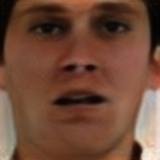

In [81]:
load_image = SuperResolveDL(model, size=56, channel=3, resize=True)
load_image('/media/angelo/DATEN/Datasets/QuisCampi-ICBRW/ICB-RW/gallery/001_f.jpg')

In [ ]:
def l2_error(a,b):
    return sum((a-b)**2) 

low_res_img_path = '/media/angelo/DATEN/Datasets/CelebA/LR_112/test/018540.jpg'
original_img_path = '/media/angelo/DATEN/Datasets/CelebA/HR/test/018540.jpg'
test_img_path = '/media/angelo/DATEN/Datasets/CelebA/HR/test/018590.jpg'

#low_res = '/media/angelo/DATEN/Datasets/Dados_TCC_Joao/Material TCC/Classe3/Classe/faces_bd/'

lr_emb = return_embedding(low_res_img_path)
hr_emb = return_embedding(original_img_path)
test_emb = return_embedding(test_img_path)

print('Identity Loss Fake Img and Real Img')
print(cos_sim(lr_emb, hr_emb))

print('Euclidean Distance Fake Img and Real Img')
print(np.linalg.norm(lr_emb-hr_emb))

print('Identity Loss Fake Img and Random Img')
print(cos_sim(lr_emb, test_emb))

print('Euclidean Distance Fake Img and Random Img')
print(np.linalg.norm(lr_emb-test_emb))

print('Identity Loss Real Img and Random Img')
print(cos_sim(hr_emb, test_emb))

print('Euclidean Distance Real Img and Random Img')
print(np.linalg.norm(hr_emb-test_emb))

In [75]:
# Checking consistency

img_path = '/media/angelo/DATEN/Datasets/QuisCampi-ICBRW/ICB-RW/'

gallery_path = gb.glob(img_path + 'gallery/*.jpg')
gallery_names = [os.path.splitext(name)[0][:-2] for name in os.listdir(img_path + 'gallery/')]

face_embeddings = return_batch_embedding(gallery_path)

probe_path = img_path + 'probe/'
student_pool_list = gallery_names

real_embedding = return_embedding(img_path + 'gallery/' + student_pool_list[0] + '_f.jpg')

guilty_student_path = gb.glob(probe_path + student_pool_list[0] + '*.jpg')
sample_1_student = gb.glob(probe_path + student_pool_list[1] + '*.jpg')
sample_2_student = gb.glob(probe_path + student_pool_list[2] + '*.jpg')
sample_3_student = gb.glob(probe_path + student_pool_list[3] + '*.jpg')

print('For student ' + student_pool_list[0])
print('Similarity with his own probe photos: ')

guilty_student_emb = return_batch_embedding(guilty_student_path)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[1])

guilty_student_emb = return_batch_embedding(sample_1_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[2])

guilty_student_emb = return_batch_embedding(sample_2_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

print('Similarity with probe photos of ' + student_pool_list[3])

guilty_student_emb = return_batch_embedding(sample_3_student)
similarities = [cos_sim(real_embedding, guilty_student_emb[i]) for i in range(5)]
print(similarities)

For student 020
Similarity with his own probe photos: 
[1.3106251955032349, 0.40345239639282227, 1.072966329753399, 1.1241027042269707, 0.3815649151802063]
Similarity with probe photos of 040
[0.9534060880541801, 0.8916241526603699, 0.7645567953586578, 0.6623994410037994, 0.6933826804161072]
Similarity with probe photos of 060
[0.4654937982559204, 0.5500156283378601, 0.6462824046611786, 0.6284173727035522, 0.6735073029994965]
Similarity with probe photos of 001
[1.1670843362808228, 1.1392423063516617, 0.7990916073322296, 1.1358355730772018, 1.1023404225707054]


In [85]:
# Experimentation

origin_path = '/media/angelo/DATEN/Datasets/QuisCampi-ICBRW/ICB-RW/'

random.seed(1)
np.random.seed(1)

print('Score')

img_path = origin_path

gallery_path = gb.glob(img_path + 'gallery-margin/*.jpg')
gallery_names = [os.path.splitext(name)[0][:-2] for name in os.listdir(img_path + 'gallery-margin/')]

face_embeddings = return_batch_embedding(gallery_path)

probe_path = img_path + 'probe/'
student_pool_list = gallery_names
average_accuracy = 0

for n_time in range(5): # Execute 5 times to check consistency of results
    accuracy = 0
    error = []
    for index, student in enumerate(student_pool_list):
        probe_list_students = student_pool_list.copy()
        watch_list_emb = []
        watch_list_images = []

        # First embeddings is always for the guilty student
        guilty_student_image = random.choice(gb.glob(probe_path + student + '*'))
        
        watch_list_emb.append(return_embedding(guilty_student_image))

        probe_list_students.remove(student)

        watch_list_students = random.sample(probe_list_students, 4)

        for suspect in watch_list_students:
            image = random.choice(gb.glob(probe_path + suspect + '*'))
            watch_list_emb.append(return_embedding(image))            

        similarities = [cos_sim(face_embeddings[index], watch_list_emb[i]) for i in range(5)]

        # If the least distance is the first element, let's sum 1
        if np.argmin(np.array(similarities)) == 0:
            accuracy += 1
        else:
            error.append(student)

    average_accuracy += accuracy/len(student_pool_list)

    print("Accuracy: {0:.3f}".format(accuracy/len(student_pool_list)))
    #print('Error happend with the following students: ')
    #print(error)
print('Average accuracy was {:.3f}'.format(100*average_accuracy/5))
print('_____________________________________________________________')

Score
Accuracy: 0.267
Accuracy: 0.322
Accuracy: 0.333
Accuracy: 0.211
Accuracy: 0.300
Average accuracy was 28.667
_____________________________________________________________
